# Stock Market Pre-Crisis Prediction

The main goal is to predict on time whether or not there is currently a stock bubble growing in order to stop it on time and avoid a big economical crisis to happen. This is an optimistic point of view since "bad brokers" make most of the profit in those critical periods. However, the idea is to find out how easy is to predict this situations for a good purpose.

As mentioned, the labels to predict in the time series of the stock market prices are:
* Period before crisis (stock market bubble)
* Standard period
* Crisis

In this notebook, two types of algorithms will be test and optimized, support vector machines and random forest classifier. They follow a complete different logic and it is interesting to explore which of them perform better for this special classification problem.

Hyperparameters will be optimized and the trained models will be tested with NYA and N255 time series.

In [24]:
import sys
from pandas.core import datetools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
sys.path.append("../..")
from src.helpers import complete_crisis_annotation
from src.plotter import plot_time_series
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%reload_ext autoreload
%autoreload 2

### Load train and test sets

In [25]:
# load data sets
data = pd.read_csv('../../data/S_and_P_500_50_18.csv').loc[:,('Date','Open')]
train = pd.read_csv('../../data/train_crisis_annotation.csv')
test = pd.read_csv('../../data/test_crisis_annotation.csv')

# label to integer
label_mapper = {'crisis': 0,
                'standard': 1,
                'pre_crisis': 2}

# split x, y
y = train.loc[:,'label']
y = y.apply(lambda x: label_mapper[x])
X = train.drop(['Date','Open','label'], axis=1)
X_test = test.drop(['Date','Open'], axis=1)

# build train/evaluation sets
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.1, random_state=42)

## Train a classification algorithm

In [26]:
# Annotation correction parameters
thrs_btw_crisis_i = 365 / 2
thrs_btw_crisis_g = 365 / 4
thrs_btw_precrisis_i = 365*2
thrs_btw_precrisis_g = 365 #/ 2

annotation_column = 'label'
label_mapper_invers = {v:k for k,v in label_mapper.items()}

### Support Vector Machines

Hyperparameters optimized after grid search
* kernel = rbf
* C = 1.0

clf_svc.best_estimator_

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [27]:
#svc = SVC()
#svc_parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
#clf_svc = GridSearchCV(svc, svc_parameters)
#clf_svc.fit(X_train.as_matrix(), y_train.as_matrix())

In [28]:
#clf_svc.best_estimator_

In [29]:
svc = SVC(kernel='rbf', C=1.0)
svc.fit(X_train.as_matrix(), y_train.as_matrix())
y_predict = svc.predict(X_eval)
print(classification_report(y_eval, y_predict))

             precision    recall  f1-score   support

          0       0.84      0.92      0.88       172
          1       0.87      0.90      0.88       630
          2       0.86      0.78      0.82       400

avg / total       0.86      0.86      0.86      1202



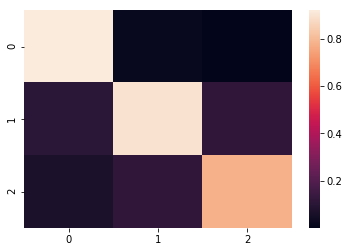

In [31]:
sns.heatmap(confusion_matrix(y_eval, y_predict) / confusion_matrix(y_eval, y_predict).sum(axis=1))

There are specially problems on recognizing the periods pre-crisis which are our main interest.

###### Test the model with the test data set

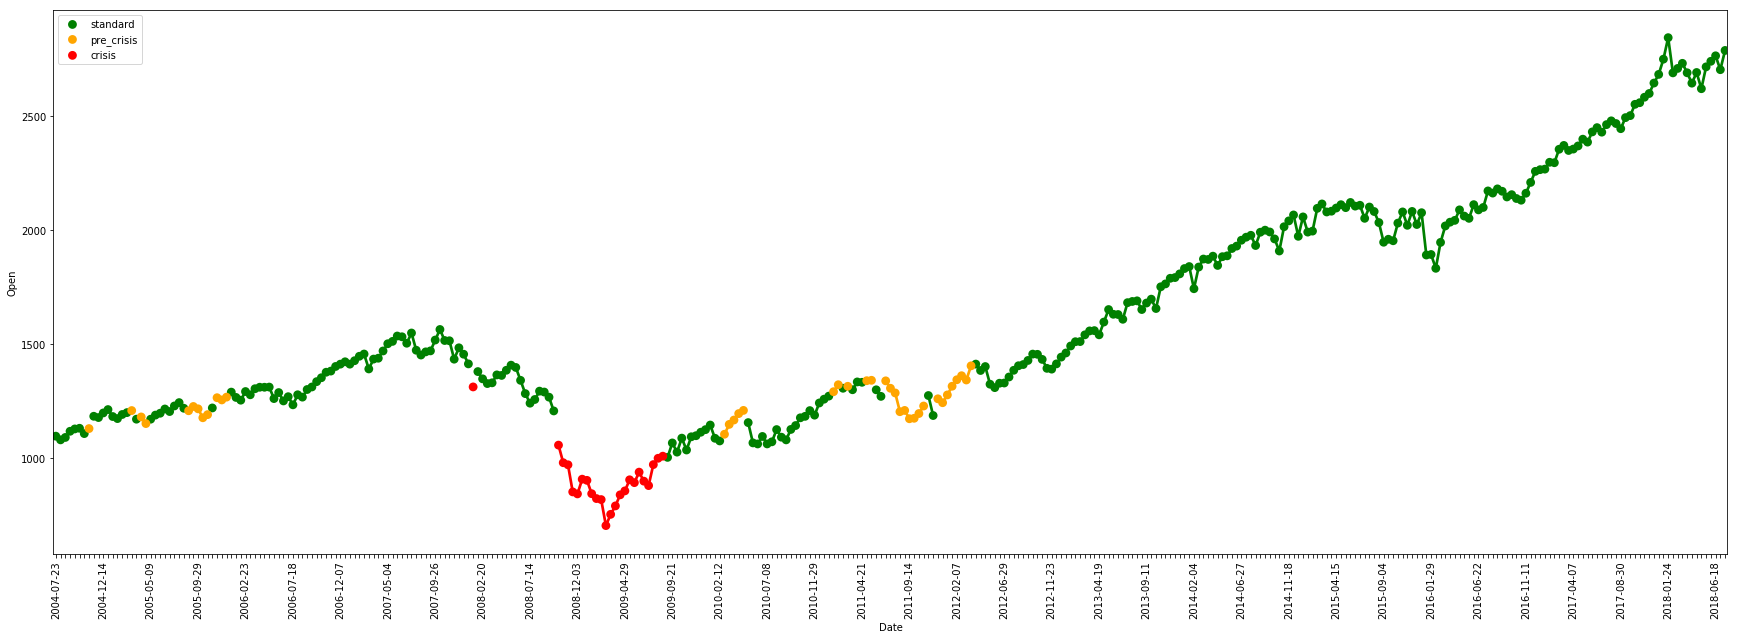

In [49]:
# predict labels for S&P 500 index
y_test_pred = svc.predict(X_test)
y_test_pred = [label_mapper_invers[pred] for pred in y_test_pred]

# add dates and open prices
pred = pd.DataFrame({'date': test['Date'], 'label': y_test_pred})
pred = data.merge(pred, left_on='Date', right_on='date')
plot_time_series(pred, 'Date', 'Open', 'label', ['green', 'orange', 'red'])

#### Test SVM with NYA index dataset

In [33]:
test_nya = pd.read_csv("../../data/nya_test.csv")
X_nya = test_nya.loc[:,('residual', 'gradient_2', 'gradient_4', 'gradient_8', 'gradient_16', 'gradient_32')]

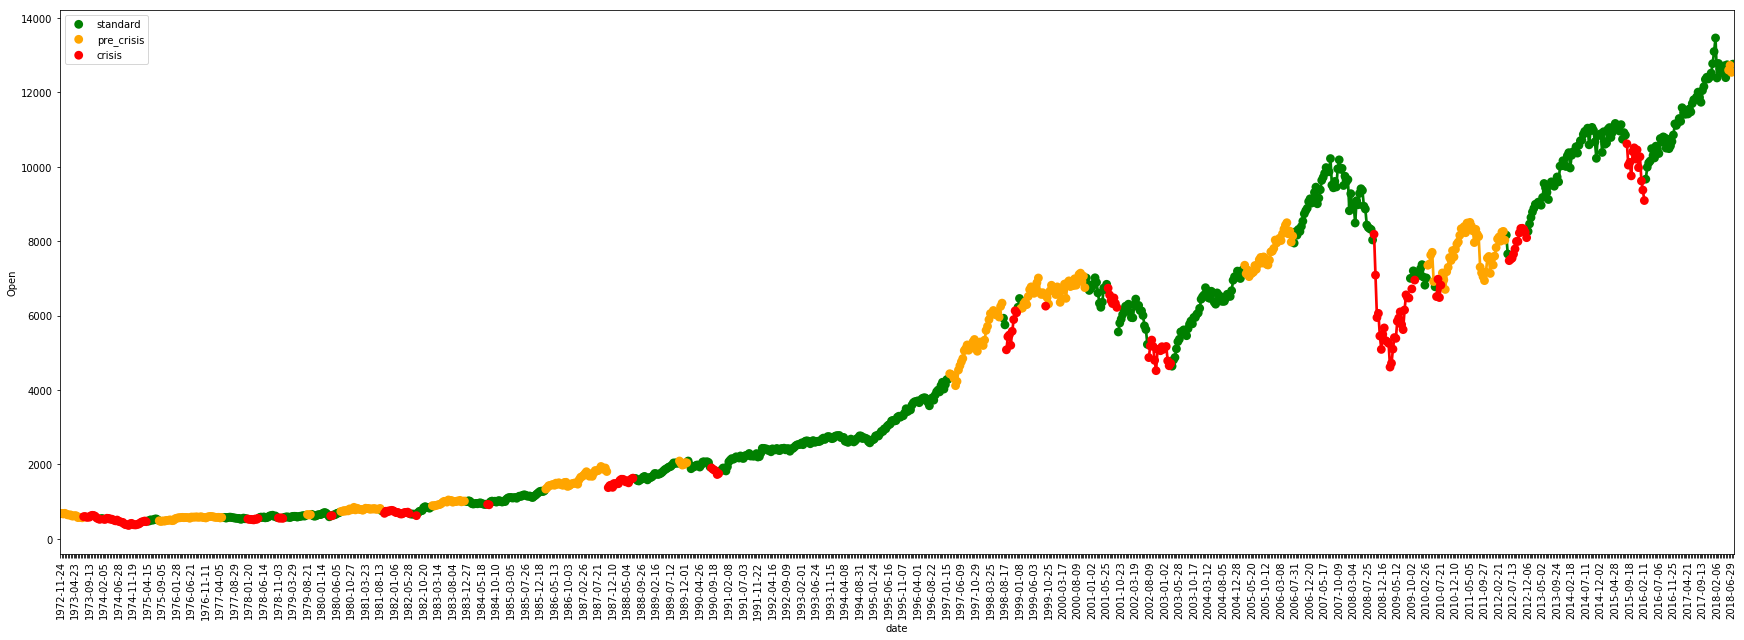

In [48]:
# predict labels for nya index
y_nya_pred = svc.predict(X_nya)
y_nya_pred = [label_mapper_invers[pred] for pred in y_nya_pred]

# add dates and open prices
pred_nya = pd.DataFrame({'date': test_nya['Date'], 'label': y_nya_pred, 'Open': test_nya['Open']})
pred_nya_c = complete_crisis_annotation(pred_nya, annotation_column, thrs_btw_crisis_i, 
                                             thrs_btw_crisis_g, thrs_btw_precrisis_i, thrs_btw_precrisis_g)
plot_time_series(pred_nya, 'date', 'Open', 'label', ['green', 'orange', 'red'])

#### Test SVM with N225 index dataset

In [35]:
test_n225 = pd.read_csv("../../data/n225_test.csv")
X_n225 = test_n225.loc[:,('residual', 'gradient_2', 'gradient_4', 'gradient_8', 'gradient_16', 'gradient_32')]

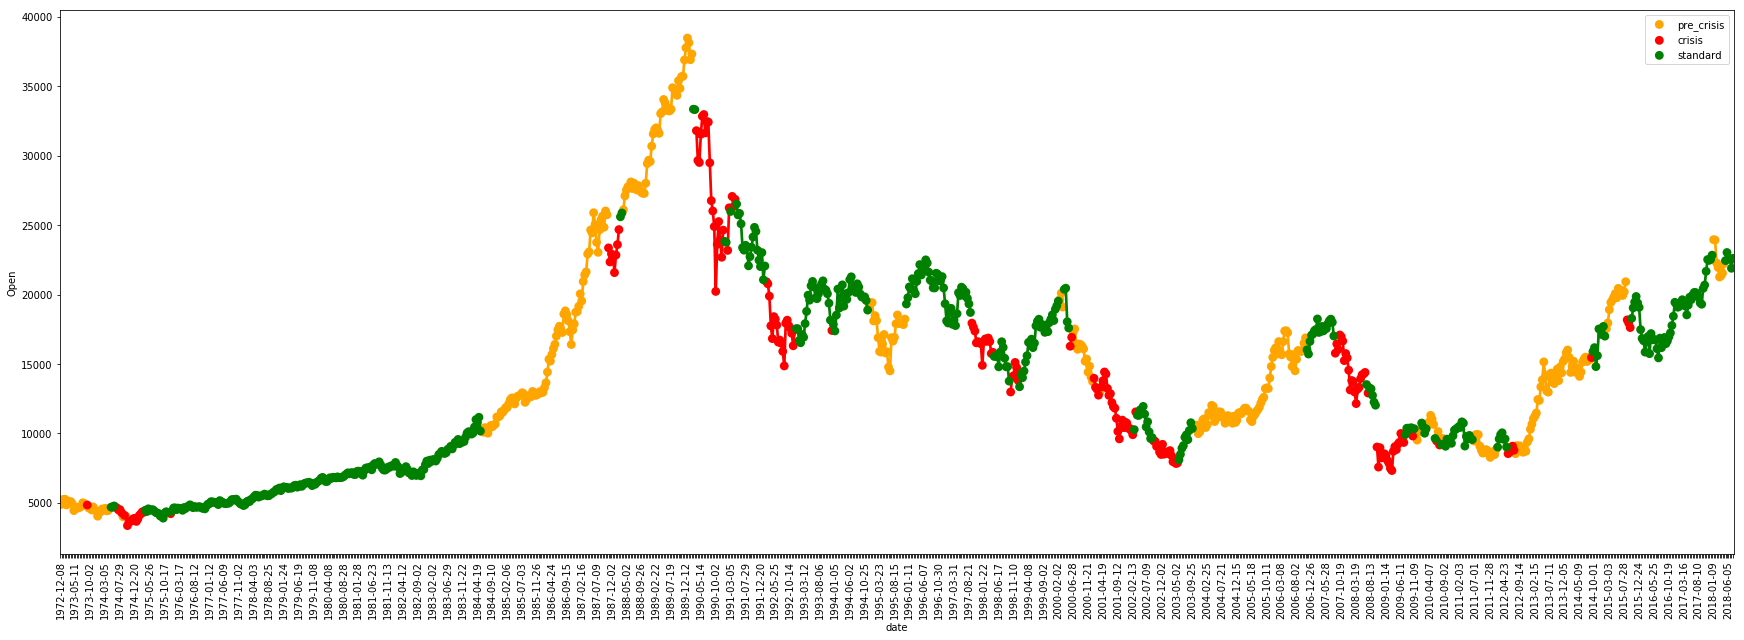

In [47]:
# predict labels for nya index
y_n225_pred = svc.predict(X_n225)
y_n225_pred = [label_mapper_invers[pred] for pred in y_n225_pred]

# add dates and open prices
pred_n225 = pd.DataFrame({'date': test_n225['Date'], 'label': y_n225_pred, 'Open': test_n225['Open']})
pred_n225_c = complete_crisis_annotation(pred_n225, annotation_column, thrs_btw_crisis_i, 
                                             thrs_btw_crisis_g, thrs_btw_precrisis_i, thrs_btw_precrisis_g)
plot_time_series(pred_n225_c, 'date', 'Open', 'label', ['orange', 'red', 'green'])

### Random forest classifier

Hyperparameters optimized after grid search:

* min_samples_leaf = 1
* n_estimators = 1200
* min_samples_split = 2
* max_depth = 50

clf_rf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1200, n_jobs=1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [37]:
#rforest = RandomForestClassifier()
#rforest_parameters = {'min_samples_leaf': [1, 2, 4], 'min_samples_split':[2, 5, 10], 
#                     'n_estimators': [200, 600, 1200], 'max_depth': [10, 50, 80, 100]}
#clf_rf = GridSearchCV(rforest, rforest_parameters)
#clf_rf.fit(X_train.as_matrix(), y_train.as_matrix())

In [38]:
#clf_rf.best_estimator_

In [39]:
rforest = RandomForestClassifier(min_samples_leaf=1, n_estimators=1200, min_samples_split=2, max_depth=50)
rforest.fit(X_train.as_matrix(), y_train.as_matrix())
y_predict = rforest.predict(X_eval)
print(classification_report(y_eval, y_predict))

             precision    recall  f1-score   support

          0       0.98      0.98      0.98       172
          1       0.99      0.99      0.99       630
          2       0.99      0.98      0.99       400

avg / total       0.99      0.99      0.99      1202



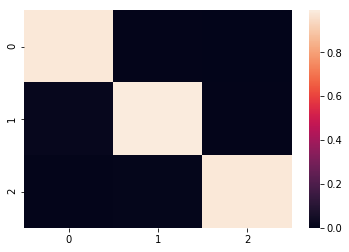

In [40]:
sns.heatmap(confusion_matrix(y_eval, y_predict) / confusion_matrix(y_eval, y_predict).sum(axis=1))

Random Forest classifier is able to correctly identify with high precision and recall the three classes. Is the model overfitting?

###### Test the model with the test dataset

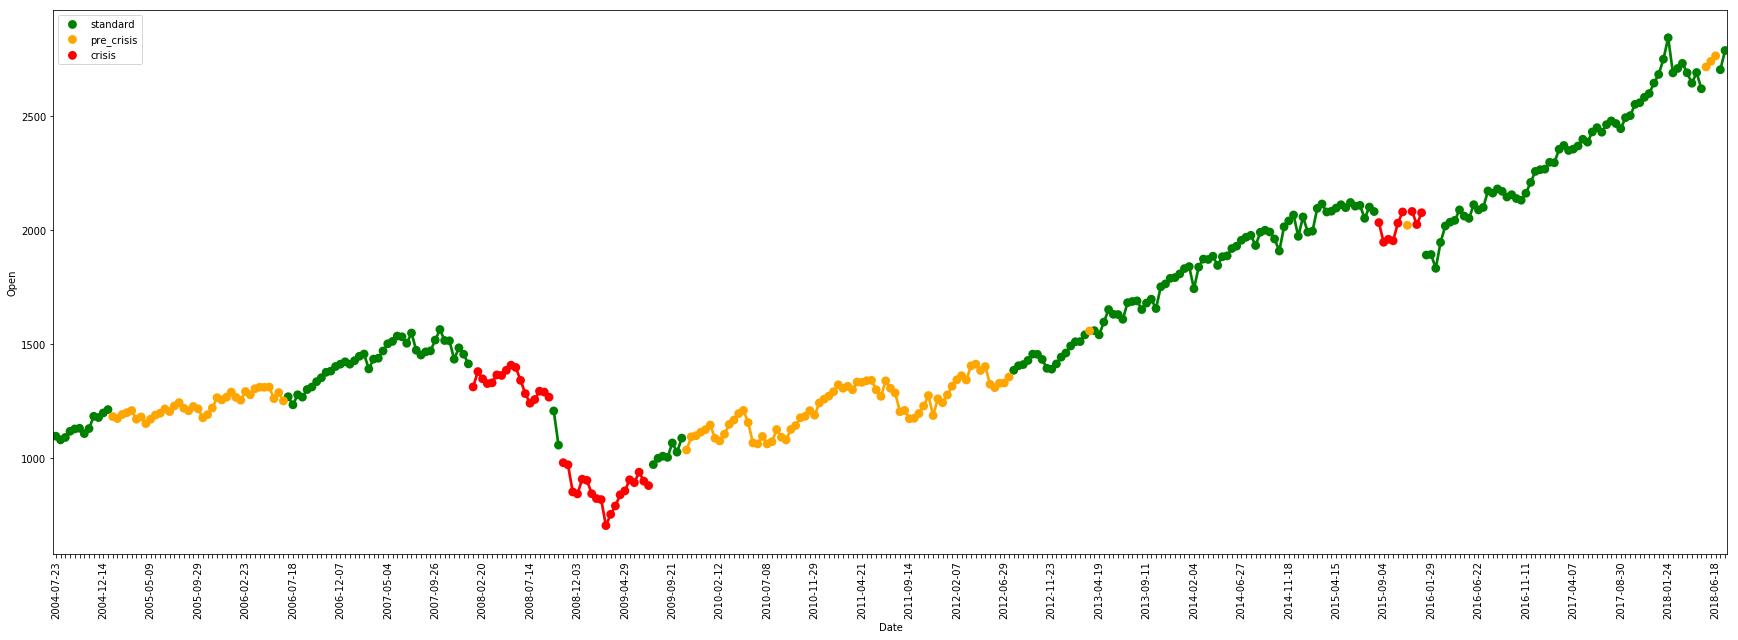

In [46]:
# predict labels for S&P 500 index
y_test_pred = rforest.predict(X_test)
y_test_pred = [label_mapper_invers[pred] for pred in y_test_pred]

# add dates and open prices
pred = pd.DataFrame({'date': test['Date'], 'label': y_test_pred})
pred = data.merge(pred, left_on='Date', right_on='date')
pred_c = complete_crisis_annotation(pred, annotation_column, thrs_btw_crisis_i, 
                                             thrs_btw_crisis_g, thrs_btw_precrisis_i, thrs_btw_precrisis_g)
plot_time_series(pred_c, 'Date', 'Open', 'label', ['green', 'orange', 'red'])

#### Test Random Forest Classifier with NYA index dataset

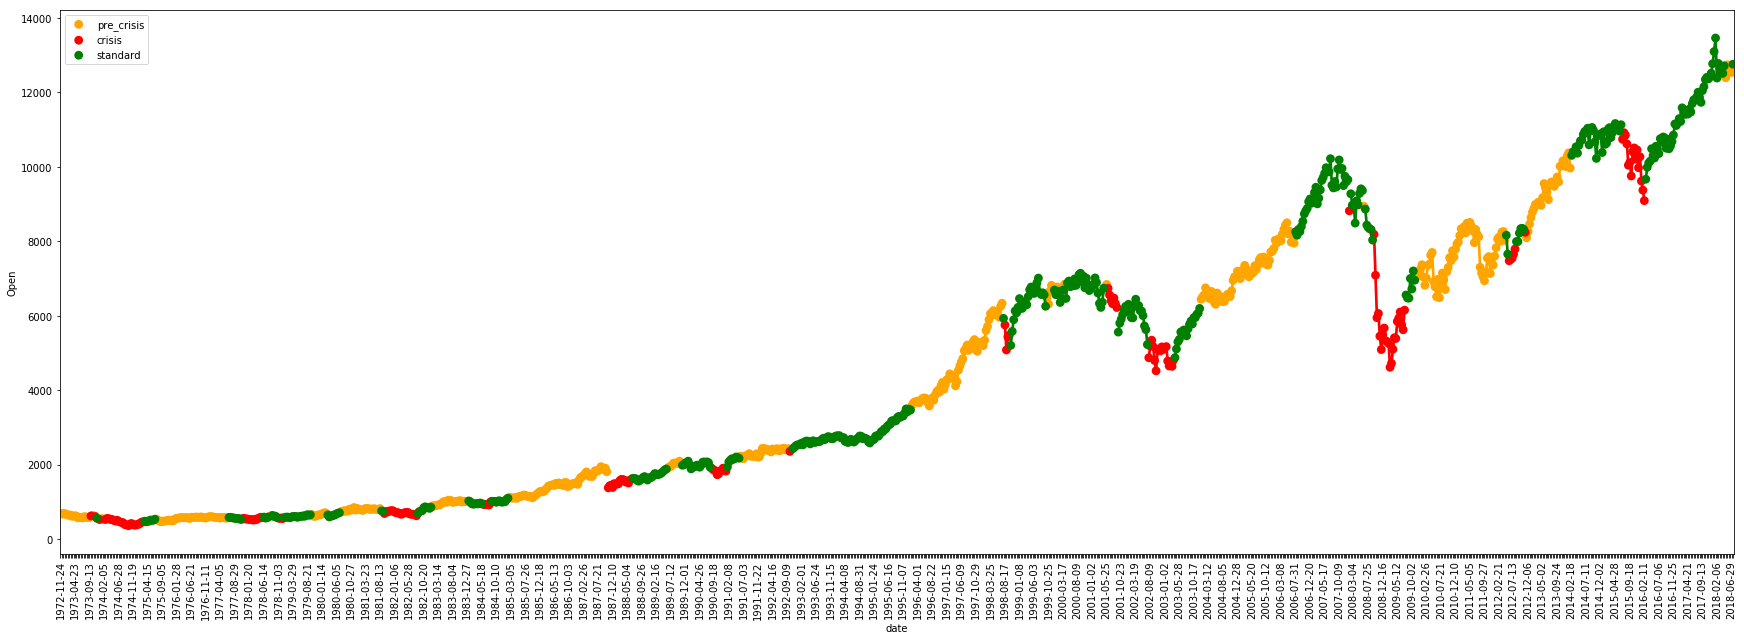

In [45]:
# predict labels for nya index
y_nya_pred = rforest.predict(X_nya)
y_nya_pred = [label_mapper_invers[pred] for pred in y_nya_pred]

# add dates and open prices
pred_nya = pd.DataFrame({'date': test_nya['Date'], 'label': y_nya_pred, 'Open': test_nya['Open']})
pred_nya_c = complete_crisis_annotation(pred_nya, annotation_column, thrs_btw_crisis_i, 
                                             thrs_btw_crisis_g, thrs_btw_precrisis_i, thrs_btw_precrisis_g)
plot_time_series(pred_nya, 'date', 'Open', 'label', ['orange', 'red', 'green'])

#### Test Random Forest Classifier with N225 index dataset

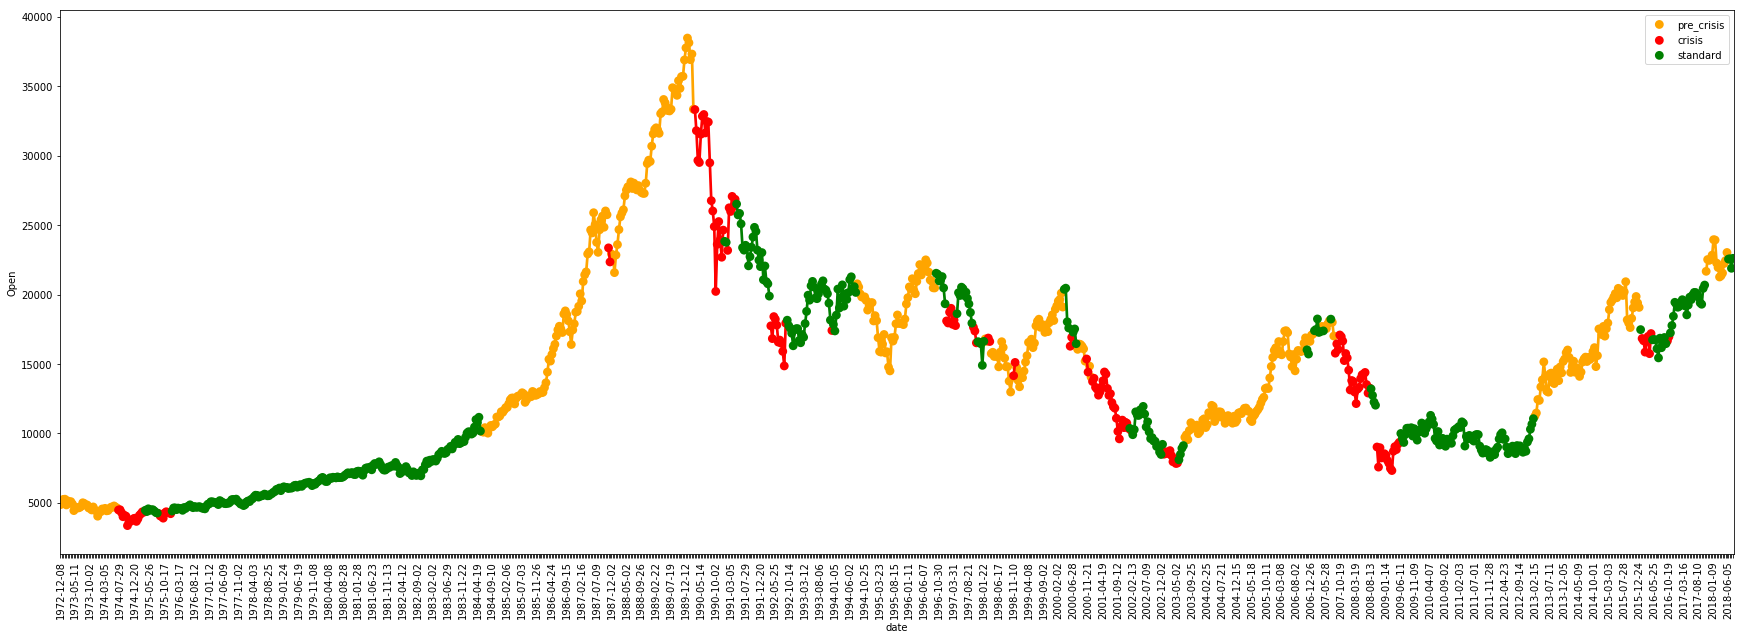

In [44]:
# predict labels for nya index
y_n225_pred = rforest.predict(X_n225)
y_n225_pred = [label_mapper_invers[pred] for pred in y_n225_pred]

# add dates and open prices
pred_n225 = pd.DataFrame({'date': test_n225['Date'], 'label': y_n225_pred, 'Open': test_n225['Open']})
pred_n225_c = complete_crisis_annotation(pred_n225, annotation_column, thrs_btw_crisis_i, 
                                             thrs_btw_crisis_g, thrs_btw_precrisis_i, thrs_btw_precrisis_g)
plot_time_series(pred_n225_c, 'date', 'Open', 'label', ['orange', 'red', 'green'])